In [2]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularity
using StatsBase
using DataFrames
using RCall
using SparseArrays

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [3]:
# H, Z = read_hypergraph_data("walmart-trips", 20)
kmax = 20
H, Z = read_hypergraph_data("TrivagoClickout", kmax) # VERY good results on Trivago with 3-5 core
# H, Z = read_hypergraph_data("congress-bills", 20) 

Base.copy(H::hypergraph) = hypergraph(H.N, H.E, H.D)

In [4]:
function projectedGraph(H)
    
    n = length(H.D)
    A = CliqueExpansion(H, false, false)
    ix, jx, w = findnz(A)
    E = Dict(sort([ix[k], jx[k]]) => w[k] for k in 1:length(ix))

    H̄ = hypergraph(collect(1:n), Dict(1 => Dict(), 2 => E), [0])
    HypergraphModularity.computeDegrees!(H̄);
    return H̄
end

projectedGraph (generic function with 1 method)

In [ ]:
DF = DataFrame()

kmax = 20

for core ∈ [10, 5, 2]
    
    H, Z = read_hypergraph_data("TrivagoClickout", kmax)
        # extract core
    println("Extracting $(core)-core")

    H_, Z_ = copy(H), copy(Z)

    for i in 1:10
        H_, Z_ = subHypergraph(H_, H_.D .>= core, Z_)
    end
    
    n = length(H_.D)
    
    println("$(core)-core has $n nodes")

    for k ∈ reverse(3:kmax)
        println("  kmax = $k")
        
        for kay in keys(H_.E)
            if kay > k
                pop!(H_.E, kay)
            end
        end
        
        HypergraphModularity.computeDegrees!(H_)
        H̄ = projectedGraph(H_)
        
        Ω̂ = estimateΩEmpirically(H_, Z_; aggregator = p -> [length(p) == 1, sum(p)])
        println("    Polyadic experiments")
        print("    ")
        for i ∈ 1:20 
            print("$i ")
            Ẑ, t = @timed SuperNode_PPLouvain(H_, Ω̂; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
            Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
            Q = modularity(H_, Ẑ, Ω̂; α = nothing) - n*log(length(unique(Z)))
            ℓ = length(unique(Ẑ))
            NMI = mutualInformation(Z_, Ẑ, true)
            df = DataFrame(kmax = k, ℓ = ℓ, Q = Q, t = t, NMI = NMI, method = "Polyadic", n = n, core = core)
            DF = vcat(DF, df)
        end
        println("")

        println("    Dyadic experiments")
        print("    ")

        Ω̄ = estimateΩEmpirically(H̄, Z_; aggregator = p -> [length(p) == 1, sum(p)])
        for i ∈ 1:20
            print("$i ")
            Ẑ, t = @timed SuperNode_PPLouvain(H̄, Ω̄; α = 0, verbose = false, clusterpenalty = n)
            Ω̄ = estimateΩEmpirically(H̄, Ẑ; aggregator = p -> [length(p) == 1, sum(p)])
            Q = modularity(H̄, Ẑ, Ω̄; α = 0)
            ℓ = length(unique(Ẑ))
            NMI = mutualInformation(Z_, Ẑ, true)
            df = DataFrame(kmax = k, ℓ = ℓ, Q = Q, method = "Dyadic", t = t, NMI = NMI, n = n, core = core)
            DF = vcat(DF, df)
        end
        println("")
    end
end

Extracting 10-core
10-core has 1327 nodes
  kmax = 20
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 19
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 18
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 17
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 16
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 15
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    D

In [12]:
R"""
library(tidyverse)
""";

In [13]:
R"""
df <- tibble($DF)

df %>% write_csv("fig/trivago_throughput.csv")
""";

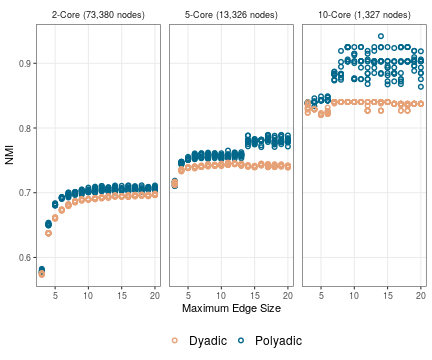

RObject{VecSxp}


In [29]:
R"""

levels <- c("2-Core (73,380 nodes)", "5-Core (13,326 nodes)", "10-Core (1,327 nodes)")

df %>% 
    arrange(desc(core)) %>% 
    group_by(method, kmax, core) %>% 
    filter(Q == max(Q)) %>% 
    filter(row_number() >= 10) %>% 
    mutate(n_ = format(n,big.mark=",",scientific=FALSE)) %>% 
    mutate(core = paste0(core, "-Core (", n_, " nodes)"),
           core = factor(core, levels = levels)) %>% 
    ggplot() + 
    aes(x = kmax, y = NMI) + 
    geom_point(pch = 21, aes(color = factor(method)), stroke = 1) + 
    facet_grid(~core) + 
    guides(color = guide_legend(title = element_blank())) + 
    xlab("Maximum Edge Size") + 
    theme_bw() +
    theme(strip.background = element_blank(),
          panel.spacing = unit(3, "mm"),
          strip.text = element_text(size = 9),
          legend.position = "bottom",
          legend.text = element_text(size = 12),
          panel.grid.minor = element_blank()) + 
    scale_color_manual(values = c("#e6a176","#00678a" ))
"""

In [27]:
R"""
ggsave("fig/trivago.png", width = 5.5, height = 3)
"""

RObject{NilSxp}
NULL


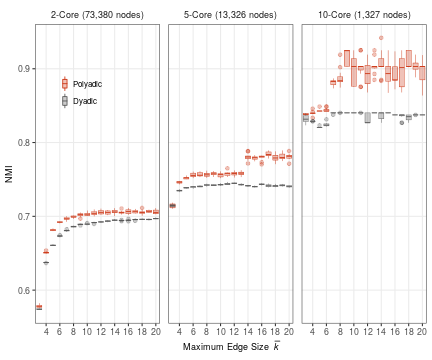

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Duplicated override.aes is ignored.
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [139]:
R"""

levels <- c("2-Core (73,380 nodes)", "5-Core (13,326 nodes)", "10-Core (1,327 nodes)")

df %>% 
    arrange(desc(core)) %>% 
    group_by(method, kmax, core) %>% 
    filter(row_number() >= 10) %>% 
    mutate(n_ = format(n,big.mark=",",scientific=FALSE)) %>% 
    mutate(core = paste0(core, "-Core (", n_, " nodes)"),
           core = factor(core, levels = levels),
           method = factor(method, levels = c("Polyadic", "Dyadic"))) %>% 
    ggplot() + 
    aes(x = factor(kmax), y = NMI) + 
    geom_boxplot(aes(color = method, fill = method),  lwd = 0.2, outlier.alpha = 0.3, position = position_identity(), alpha = 0.3) + 
    facet_grid(~core) + 
    xlab(expression("Maximum Edge Size"~italic(bar(k)))) + 
    theme_bw() +
    theme(strip.background = element_blank(),
          panel.spacing = unit(3, "mm"),
          strip.text = element_text(size = 9),
#          legend.position = "bottom",
          legend.text = element_text(size = 8),
          panel.grid.minor = element_blank(),
          legend.key.width = unit(0.4,"line"),
          legend.position = c(.12, .8),
          legend.background = element_blank(), 
          legend.key = element_rect(colour = NA, fill = NA),
          axis.title = element_text(size = 9)) + 
    scale_color_manual(name = "", 
                       values = c("#CC3311", "#555555"),
                       labels = c("Polyadic", "Dyadic")) + 
    scale_fill_manual(name = "", 
                      values = c("#CC3311", "#555555"),
                      labels = c("Polyadic", "Dyadic")) + 
    scale_x_discrete(breaks = seq(4, 20, by = 2)) + 
    guides(fill = guide_legend(override.aes = list(size = 0.4)), 
           color = guide_legend(override.aes = list(size = 0.4)))
"""

In [137]:
R"""
ggsave("fig/trivago_boxplot.png", width = 5.5, height = 2.5)
"""

┌ Warning: RCall.jl: Warning: Duplicated override.aes is ignored.
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{NilSxp}
NULL


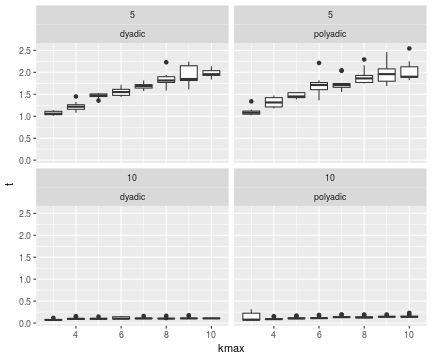

RObject{VecSxp}


In [329]:
R"""
df %>% 
    group_by(method, kmax, core) %>% 
    ggplot() + 
    aes(x = kmax, y = t, group = kmax) + 
    geom_boxplot() + 
    facet_wrap(core~method) 
"""

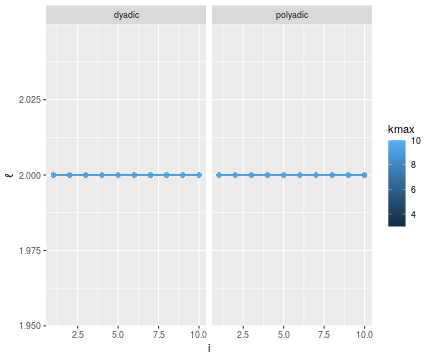

RObject{VecSxp}


In [267]:
R"""
df %>% 
    group_by(method, kmax) %>%
    mutate(i = row_number()) %>% 
    ggplot() + 
    aes(x = i, y = ℓ, color = kmax, group = kmax) + 
    geom_point() + 
    geom_line() + 
    facet_wrap(~method)
"""

In [268]:
R"""
df %>% 
    group_by(method, kmax) %>% 
    filter(Q == max(Q))
"""

RObject{VecSxp}
# A tibble: 160 x 7
# Groups:   method, kmax [16]
    kmax     ℓ       Q      t   NMI method       n
   <int> <int>   <dbl>  <dbl> <dbl> <chr>    <int>
 1     3     2 -31965. 0.0118     1 polyadic    71
 2     3     2 -31965. 0.0122     1 polyadic    71
 3     3     2 -31965. 0.0122     1 polyadic    71
 4     3     2 -31965. 0.0128     1 polyadic    71
 5     3     2 -31965. 0.0135     1 polyadic    71
 6     3     2 -31965. 0.0112     1 polyadic    71
 7     3     2 -31965. 0.0122     1 polyadic    71
 8     3     2 -31965. 0.0118     1 polyadic    71
 9     3     2 -31965. 0.0131     1 polyadic    71
10     3     2 -31965. 0.0139     1 polyadic    71
# … with 150 more rows


In [56]:
# this seems to work well: 
# set a roughly uniform resolution 
# parameter across different sizes

ωᵢ = 2.0
ωₒ = 0.6
function ω(p, α)
    num = p[1] == 1 ? ωᵢ : ωₒ
    denom = big(sum(H_.D))^sum(p[2])
    return 1000*num / denom
end

Ω = allOrNothingIntensityFunction(ω, maximum(keys(H_.E)));

In [57]:
Ẑ, t = @timed SuperNode_PPLouvain(H_, Ω; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
Q = modularity(H_, Ẑ, Ω̂; α = nothing) - n*log(length(unique(Z)))
k = length(unique(Ẑ))
println(round(Q - n * log(k)), "    ", k, "    ", t)

-5.543607e+06    1034    87.537544466


In [58]:
for i ∈ 1:10
    Ẑ, t = @timed SuperNode_PPLouvain(H_, Ω̂; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
    Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
    Q = modularity(H_, Ẑ, Ω̂; α = nothing)
    k = length(unique(Ẑ))
    penalty = round( - n * log(k))
    println(round(Q), "    ", penalty , "   ", round(Q + penalty),"    ", k, "    ", t)
end

-4.394645e+06    -412218.0   -4.806863e+06    1044    21.357420084
-4.064628e+06    -413510.0   -4.478138e+06    1067    68.847220794
-3.87094e+06    -415693.0   -4.286633e+06    1107    68.0647816
-3.790749e+06    -417953.0   -4.208702e+06    1150    73.945746394
-3.742153e+06    -419480.0   -4.161633e+06    1180    72.335793413
-3.730414e+06    -420920.0   -4.151334e+06    1209    23.261946143
-3.713118e+06    -421845.0   -4.134963e+06    1228    77.404249302
-3.707867e+06    -422374.0   -4.130241e+06    1239    24.516362609
-3.706195e+06    -422708.0   -4.128903e+06    1246    77.272736499
-3.701791e+06    -423276.0   -4.125067e+06    1258    73.258317537


In [59]:
mutualInformation(Z_, Ẑ, true)

0.708864615308239

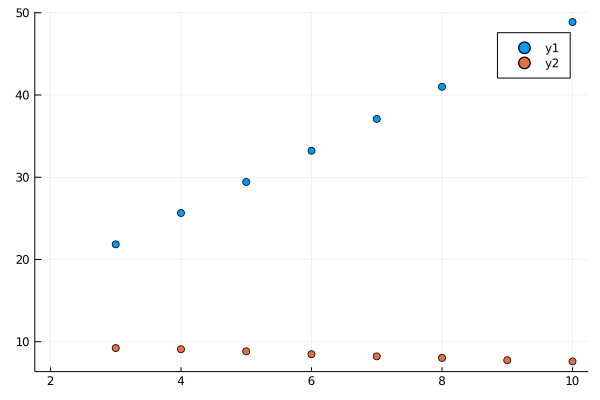

In [60]:
using Plots

v = log.([Ω̂.ω([1, i], 0) / Ω̂.ω([0, i], 0) for i in 2:kmax])

plot(collect(2:kmax),
    log.([Ω̂.ω([1, i], 0)*big(sum(H.D))^i for i in 2:kmax]), 
    seriestype = :scatter)

plot!(collect(2:kmax),
    log.([Ω̂.ω([0, i], 0)*big(sum(H.D))^i for i in 2:kmax]), 
    seriestype = :scatter)

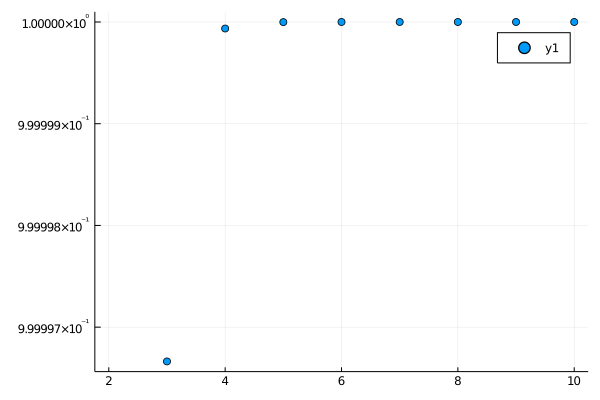

In [61]:
plot(collect(2:kmax), [Ω̂.ω([1, i], 0) / ( Ω̂.ω([0, i], 0) + Ω̂.ω([1, i], 0)) for i in 2:kmax], seriestype = :scatter)

In [62]:
Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p), sum(p)], bigNums = true);

D = evalSums(Ẑ, H_, maximum(Ẑ), true)[3]
D̄ = Dict(p => Ω̂.ω([length(p), sum(p)], 0)*D[p] for p in keys(D));
sum(collect(values(D̄)))

131140.0000000000000000000000000000000000000000000000000000000000000000000000023

In [63]:
P = Dict()
for k in keys(H_.E)
    for (e, v) in H_.E[k]
        p = partitionize(Ẑ[e])
        P[p] = get(P, p, 0) + v
    end
end

In [64]:
sum(collect(values(P)))

131140

In [65]:
# residuals
D_ = Dict(p => Float64((get(P, p, 0) - D̄[p])) for p in keys(D̄))

# sum(values(D_))
for (k, v) in D_
    if sum(k) == 4
        println(k, "   ", get(P, k, 0), "   ", v)
    end
end

[1, 1, 1, 1]   0   -0.0
[2, 2]   850   -92.11494541104874
[4]   26424   0.0
[3, 1]   1800   92.11494541104874
[2, 1, 1]   472   0.0


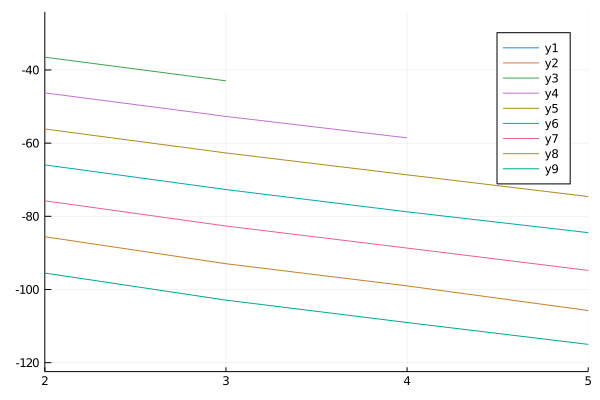

In [66]:
plot()

for i in 2:kmax
    plot!(collect(2:i), [log(Ω̂.ω([k, i], 0)) for k in 2:i])
end

plot!(xlims = (2, 5))

In [69]:
# AIC for the length measure, preferred over AON for this data
Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p), sum(p)], bigNums = true);

num_params = kmax*(kmax-1)/2
L = 2*(modularity(H_, Ẑ, Ω̂; α = 0) - n*log(k))
AIC = L - 2*num_params
BIC = L - num_params*(kmax*log(n) - sum(log(i) for i in 2:kmax))
Float64(AIC), Float64(BIC)

(-8.054704114429893e6, -8.058880117868413e6)

In [70]:
# AIC for the AON cut

Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);

num_params = kmax - 1
L = 2*(modularity(H_, Ẑ, Ω̂; α = 0) - n*log(k))
AIC = L - 2*num_params
BIC = L - num_params*(kmax*log(n) - sum(log(i) for i in 2:kmax))
Float64(AIC), Float64(BIC)

(-8.250151729627548e6, -8.250986930315251e6)

AIC and BIC are probably good things to do here, even if the fast algorithm doesn't quite work for the non-AON cuts. Principled story about model selection would be really good. Annoying problem: correctly stating the number of observations.

In [71]:
function ω(p, α)
    k = big(sum(p))
    return k/sum((p .* (1:length(p)).^α[k])) / n^(α[kmax+k]*k)
end

Ω = partitionIntensityFunction(ω, kmax);
α0 = vcat(repeat([1.0], kmax), 1:kmax);

In [72]:
using Optim
α̂ = learnParameters(H_, Ẑ, Ω, α0; n_iters = 20, verbose = true);    

-4.999454293796865e6
-4.618153422403107e6
-4.260462075816548e6
-4.004400373842957e6
-3.8731785640038173e6
-3.784778664238286e6
-3.731646737300687e6
-3.6924197203622176e6
-3.667179300260388e6
-3.648820543693396e6
-3.636433310988673e6
-3.6269739904197897e6
-3.620478487526476e6
-3.615280271441635e6
-3.6117271734730275e6
-3.609766373697348e6
-3.608697736813359e6
-3.607821440019501e6
-3.6071979112827335e6
-3.6070199673479917e6


20-element Array{Float64,1}:
  1.0
  1.0
 14.34848244654724
 14.758728877898484
 15.455430468408021
 16.35464961395791
 17.298416774057007
 18.25415045519669
 19.364349017028434
 20.171060668281225
 92.45246956064045
 16.13022397465688
  0.554015109005713
  0.6327189901266956
  0.6805632307237864
  0.7118847319340983
  0.7334132074090813
  0.7490087008995356
  0.7603675986269302
  0.7725751808971358

In [73]:
α̂ = learnParameters(H_, Ẑ, Ω, α̂; n_iters = 20, verbose = true);    

-3.607007932355571e6
-3.6070076000542114e6
-3.607007592736339e6
-3.607007592581014e6
-3.6070075925777326e6
-3.607007592577663e6
-3.6070075925776614e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6
-3.607007592577661e6


In [74]:
α̂

20-element Array{Float64,1}:
  1.0
  1.0
 14.34848244654724
 14.758728877898484
 15.455430468408021
 16.354649614488586
 17.298416841275333
 18.254164524838835
 19.36446956413434
 20.299625662311293
 92.45246956064045
 16.13022397465688
  0.554015109005713
  0.6327189901266956
  0.6805632307237128
  0.711884731923924
  0.7334132061678384
  0.7490084461440487
  0.7603654942607672
  0.7703673326810474

In [79]:
v = [6, 3, 2, 1]
(sum(v*v') - v'*v)/2

47.0

In [93]:
function ω(p, α)
    k = big(sum(p))
    dcut = big((sum(p*p') - p'*p)/2)
    return k/((1 + dcut)^α[k])/ n^(α[kmax+k]*k)
end

Ω₀ = partitionIntensityFunction(ω, kmax);
α0 = vcat(repeat([1.0], kmax), 1:kmax);

using Optim
α̂ = learnParameters(H_, Ẑ, Ω₀, α0; n_iters = 20, verbose = true);    

-4.904198702259071e6
-4.571385006257608e6
-4.251044029809998e6
-4.0347354931475716e6
-3.924530063487615e6
-3.845228904135363e6
-3.7999363593133506e6
-3.7626829314931133e6
-3.736733987068712e6
-3.718647534571205e6
-3.703678887910961e6
-3.6933929686879287e6
-3.685139942600275e6
-3.6780835980945807e6
-3.6730461663397094e6
-3.6689750656653796e6
-3.6652620522422297e6
-3.662346528276046e6
-3.6603747271184316e6
-3.65905330655427e6


In [94]:
α̂

20-element Array{Float64,1}:
  1.0
  1.0
  9.403997229268617
  8.709799429061102
  8.739326928772941
  9.05450695024631
  9.456531441138202
  9.887387147243238
 10.201899160765343
  8.746925277551988
 92.45246956064045
 23.260994293916134
  0.587150825635639
  0.663988439988976
  0.7097157978742469
  0.7391526106314135
  0.7590284235070248
  0.773587970001321
  0.7911337789252074
  0.8659295255669716